# Clustering - Phân cụm cầu thủ và đội bóng

Notebook này thực hiện phân cụm cầu thủ và đội bóng theo phong cách chơi sử dụng K-Means và Hierarchical Clustering.

## Mục tiêu:
1. Chọn features phù hợp
2. Scale dữ liệu
3. Tìm số cụm tối ưu
4. Áp dụng K-Means và Hierarchical Clustering
5. Phân tích và visualize các cụm


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from clustering import (
    select_features_for_clustering, find_optimal_clusters,
    perform_kmeans_clustering, perform_hierarchical_clustering,
    analyze_clusters, reduce_dimensions_for_visualization
)
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Đã import các modules cần thiết")


✅ Đã import các modules cần thiết


## 1. Load và chuẩn bị dữ liệu


In [2]:
# Load dữ liệu
try:
    players_df = pd.read_excel('../data/players_processed.xlsx')
    print(f"✅ Đã load dữ liệu cầu thủ: {players_df.shape}")
except:
    from data_preprocessing import load_data, feature_engineering_players, prepare_data_for_analysis
    data = load_data()
    players_df = feature_engineering_players(data['players'])
    players_df = prepare_data_for_analysis(players_df)
    print(f"✅ Đã load và xử lý: {players_df.shape}")

# Chọn features cho clustering
feature_cols = select_features_for_clustering(players_df)
print(f"\n📊 Đã chọn {len(feature_cols)} features cho clustering")
print(f"Features: {feature_cols[:10]}...")

# Lọc dữ liệu và scale
X = players_df[feature_cols].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Đã scale dữ liệu: {X_scaled.shape}")


✅ Đã load dữ liệu cầu thủ: (574, 146)

📊 Đã chọn 100 features cho clustering
Features: ['90s_shooting', 'shooting_Standard_Gls', 'shooting_Standard_Sh', 'shooting_Standard_SoT', 'shooting_Standard_Sh/90', 'shooting_Standard_SoT/90', 'shooting_Standard_G/Sh', 'shooting_Standard_G/SoT', 'shooting_Standard_Dist', 'shooting_Standard_FK']...

✅ Đã scale dữ liệu: (574, 100)


## 2. Tìm số cụm tối ưu


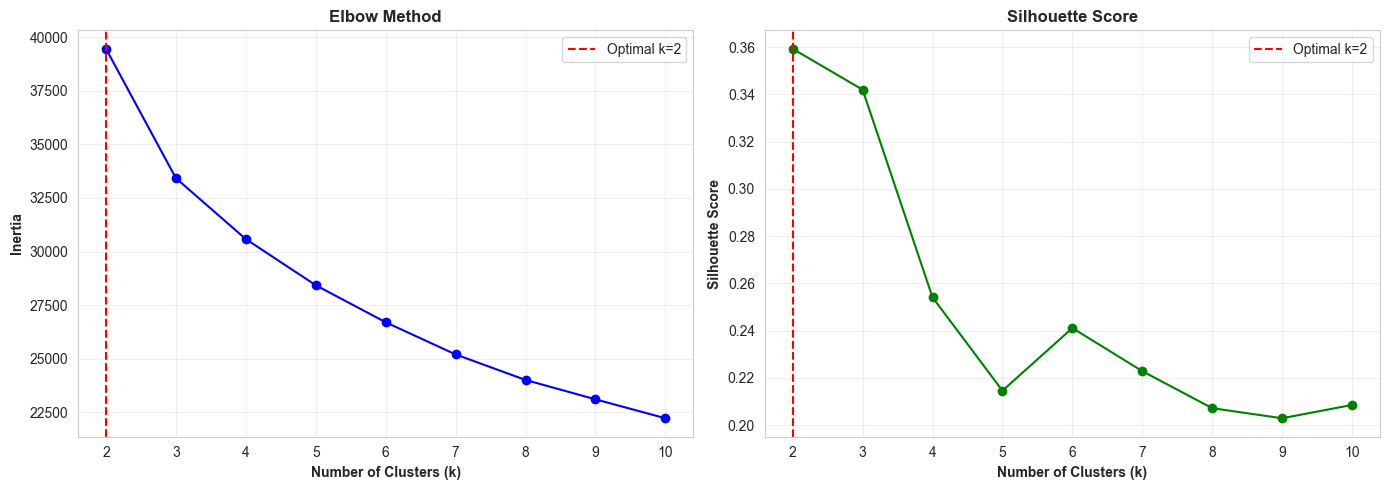

✅ Số cụm tối ưu: 2


In [3]:
# Tìm số cụm tối ưu
optimal_results = find_optimal_clusters(X_scaled, max_k=10, method='kmeans')

# Visualize Elbow Method và Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method
ax1 = axes[0]
ax1.plot(optimal_results['k_range'], optimal_results['inertias'], 'bo-')
ax1.axvline(x=optimal_results['optimal_k'], color='r', linestyle='--', label=f'Optimal k={optimal_results["optimal_k"]}')
ax1.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax1.set_ylabel('Inertia', fontweight='bold')
ax1.set_title('Elbow Method', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2 = axes[1]
ax2.plot(optimal_results['k_range'], optimal_results['silhouette_scores'], 'go-')
ax2.axvline(x=optimal_results['optimal_k'], color='r', linestyle='--', label=f'Optimal k={optimal_results["optimal_k"]}')
ax2.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontweight='bold')
ax2.set_title('Silhouette Score', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/clustering/optimal_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Số cụm tối ưu: {optimal_results['optimal_k']}")


## 3. K-Means Clustering


In [4]:
# Thực hiện K-Means clustering
kmeans_results = perform_kmeans_clustering(X_scaled, find_optimal=True, max_k=10)

print(f"\n📊 Kết quả K-Means:")
print(f"  - Số cụm: {kmeans_results['n_clusters']}")
print(f"  - Silhouette Score: {kmeans_results['silhouette_score']:.3f}")
print(f"  - Davies-Bouldin Score: {kmeans_results['davies_bouldin_score']:.3f}")

# Phân tích các cụm
cluster_stats = analyze_clusters(players_df, kmeans_results['labels'], feature_cols)
print("\n📈 Thống kê các cụm:")
print(cluster_stats)

# Thêm cluster labels vào dataframe
players_df['Cluster_KMeans'] = kmeans_results['labels']
print(f"\n📊 Phân bố cầu thủ theo cụm:")
print(players_df['Cluster_KMeans'].value_counts().sort_index())


🔍 Đang tìm số cụm tối ưu...
✅ Số cụm tối ưu: 2 (Silhouette Score: 0.359)

📊 Kết quả K-Means:
  - Số cụm: 2
  - Silhouette Score: 0.359
  - Davies-Bouldin Score: 1.360

📈 Thống kê các cụm:
         90s_shooting  shooting_Standard_Gls  shooting_Standard_Sh  \
Cluster                                                              
0            7.456354               0.640884              6.770718   
1           26.623113               4.009434             34.509434   

         shooting_Standard_SoT  shooting_Standard_Sh/90  \
Cluster                                                   
0                     2.287293                 1.464586   
1                    11.589623                 1.320755   

         shooting_Standard_SoT/90  shooting_Standard_G/Sh  \
Cluster                                                     
0                        0.664006                0.051298   
1                        0.439717                0.088585   

         shooting_Standard_G/SoT  shooting_Standa

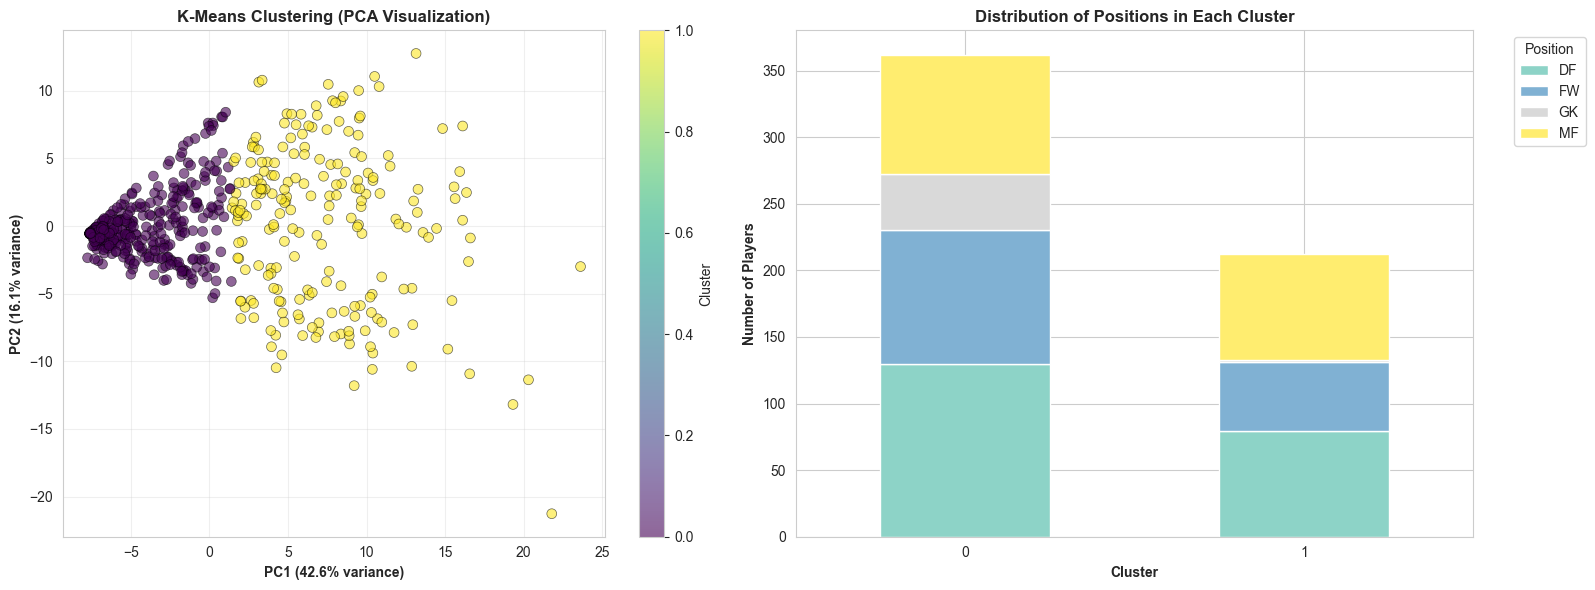

In [5]:
# Visualize clusters với PCA
X_pca, pca = reduce_dimensions_for_visualization(X_scaled, n_components=2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot với colors theo cluster
ax1 = axes[0]
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_results['labels'], 
                     cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
ax1.set_title('K-Means Clustering (PCA Visualization)', fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Cluster')
ax1.grid(True, alpha=0.3)

# Phân bố theo vị trí và cluster
ax2 = axes[1]
if 'Pos' in players_df.columns:
    cluster_pos = pd.crosstab(players_df['Cluster_KMeans'], players_df['Pos'])
    cluster_pos.plot(kind='bar', ax=ax2, stacked=True, colormap='Set3')
    ax2.set_xlabel('Cluster', fontweight='bold')
    ax2.set_ylabel('Number of Players', fontweight='bold')
    ax2.set_title('Distribution of Positions in Each Cluster', fontweight='bold')
    ax2.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../results/clustering/kmeans_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Hierarchical Clustering


🔍 Đang tìm số cụm tối ưu...
✅ Số cụm tối ưu: 5 (Silhouette Score: 0.346)

📊 Kết quả Hierarchical Clustering:
  - Số cụm: 5
  - Silhouette Score: 0.346
  - Davies-Bouldin Score: 1.576

📈 Thống kê các cụm (Hierarchical):
         90s_shooting  shooting_Standard_Gls  shooting_Standard_Sh  \
Cluster                                                              
0            6.490598               0.726496              7.717949   
1           27.443243               5.135135             48.810811   
2           26.780000               1.516667             19.200000   
3           32.168421               0.000000              0.105263   
4           26.061702               9.680851             62.680851   

         shooting_Standard_SoT  shooting_Standard_Sh/90  \
Cluster                                                   
0                     2.555556                 1.550883   
1                    15.135135                 1.764054   
2                     5.433333                 0.72991

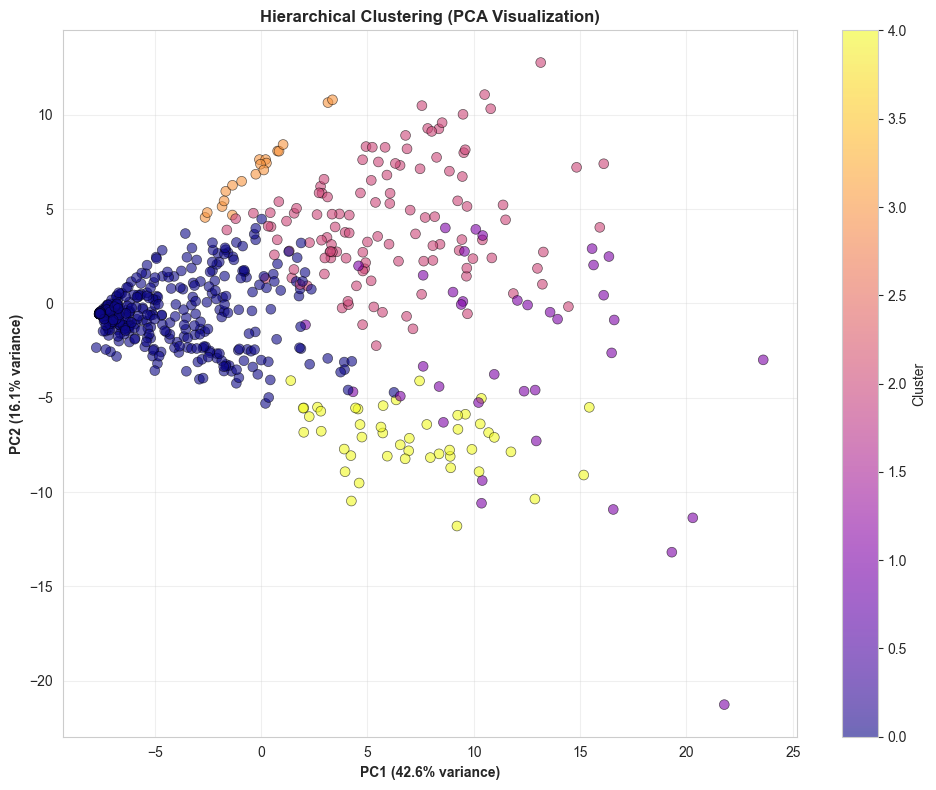


✅ Đã lưu kết quả clustering


In [6]:
# Thực hiện Hierarchical Clustering
hierarchical_results = perform_hierarchical_clustering(X_scaled, find_optimal=True, max_k=10, linkage='ward')

print(f"\n📊 Kết quả Hierarchical Clustering:")
print(f"  - Số cụm: {hierarchical_results['n_clusters']}")
print(f"  - Silhouette Score: {hierarchical_results['silhouette_score']:.3f}")
print(f"  - Davies-Bouldin Score: {hierarchical_results['davies_bouldin_score']:.3f}")

# Phân tích các cụm
cluster_stats_hier = analyze_clusters(players_df, hierarchical_results['labels'], feature_cols)
print("\n📈 Thống kê các cụm (Hierarchical):")
print(cluster_stats_hier)

players_df['Cluster_Hierarchical'] = hierarchical_results['labels']
print(f"\n📊 Phân bố cầu thủ theo cụm (Hierarchical):")
print(players_df['Cluster_Hierarchical'].value_counts().sort_index())

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_results['labels'], 
                    cmap='plasma', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
ax.set_title('Hierarchical Clustering (PCA Visualization)', fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/clustering/hierarchical_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Lưu kết quả
players_df[['Player', 'Pos', 'Squad', 'Cluster_KMeans', 'Cluster_Hierarchical']].to_csv(
    '../results/clustering/player_clusters.csv', index=False)
print("\n✅ Đã lưu kết quả clustering")
